# CatBoost : SKLearn API HyperOpt Search

Read Titanic Data

Split Data : Train, Validation, Test

Convert Data to CatBoost Data Structure

Build Model using SKLearn API

Model using Cross-Validation

Model using HyperOpt Search #GridSearchCV, RandomizedSearchCV

Predict on Test Data

Performance Measure

Plot Merics

SHAP Analysis

Probability Calibration 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn import metrics 

In [3]:
from catboost import CatBoostClassifier, Pool, cv

In [4]:
import hyperopt

### Read Data

In [5]:
# import seaborn as sns
# train_df = sns.load_dataset('titanic')
# train_df = train_df.drop(['who','alive','alone'], axis=1)

In [6]:
# """CatBoost"""
#from catboost.datasets import titanic
#train_df, test_df = titanic()

In [7]:
# null_value_stats = train_df.isnull().sum(axis=0)
# null_value_stats[null_value_stats != 0]
# train_df.fillna(-9999, inplace=True)
# test_df.fillna(-9999, inplace=True)

In [8]:
# X = train_df.drop('Survived', axis=1)
# y = train_df.Survived

In [9]:
from ipynb.fs.full.dataProcessing_titanicData import *

In [10]:
train_df, test_df = train_test_ordinal

In [11]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

#### Split Data

In [12]:
"""Setting the Seed"""
theSeed = 209

In [13]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.80, random_state=theSeed)
print(f'train data: {X_train.shape}')
print(f'valid data: {X_valid.shape}')

train data: (785, 14)
valid data: (197, 14)


In [15]:
#X_test = test_df
X_test = test_df.drop(['Survived'], axis=1)
y_test = test_df.Survived
print(f'test data : {X_test.shape}')

test data : (327, 14)


#### Setting Weight to the Data

In [16]:
# class_weights = [1.85, 2.17]
# scale_pos_weight = np.random.rand(X_train.shape[0], )
# weight = np.random.rand(X_train.shape[0], )

#### CatBoost Data Structure 

In [17]:
# train_data = Pool(X_train, label=y_train, cat_features=categorical_features_indices, weight=None)
# valid_data = Pool(X_valid, label=y_valid, cat_features=categorical_features_indices, weight=None)
# test_data  = Pool(X_test, label=y_test, cat_features=categorical_features_indices, weight=None)

In [18]:
train_data = Pool(X_train, label=y_train, weight=None)
valid_data = Pool(X_valid, label=y_valid, weight=None)
test_data  = Pool(X_test, label=y_test, weight=None)

### Train Model

#### Cross-Validation

In [19]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

In [20]:
cvmodel = CatBoostClassifier(
    loss_function='Logloss',
    custom_loss=['Accuracy','Logloss','F1'],
    eval_metric='AUC', 
    iterations=100,
    learning_rate=0.03, 
    l2_leaf_reg=3.0, 
    #cat_features=categorical_features_indices,
    logging_level='Silent',
    early_stopping_rounds=None,
    model_shrink_mode=None,
    use_best_model=False,
    random_seed=theSeed)

In [21]:
y_pred = cross_val_predict(cvmodel, X_train, y_train, cv=5)

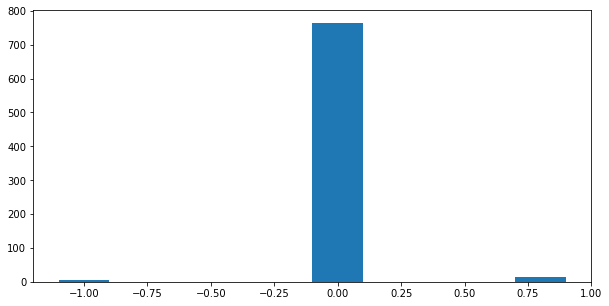

[0.00764331 0.         0.         0.         0.         0.97324841
 0.         0.         0.         0.01910828]


In [22]:
fig, ax = plt.subplots( figsize=(10,5) )

y_delta = y_train.to_numpy() - y_pred
n, bins, patches = ax.hist(y_delta, density=False, histtype='bar', rwidth=2.5, align='left', stacked=False)
plt.show()
print( n/len(y_pred) )

In [23]:
scores = cross_val_score(cvmodel, X_train, y_train, scoring='accuracy', cv=5)
scores

array([0.96815287, 0.96178344, 0.96815287, 0.98089172, 0.98726115])

In [24]:
scores = cross_validate(cvmodel, X_train, y_train, scoring=['accuracy','roc_auc','f1'], cv=5)
scores

{'fit_time': array([0.11075401, 0.10123181, 0.10727096, 0.10529923, 0.11025476]),
 'score_time': array([0.0042212 , 0.00430799, 0.00436282, 0.00458097, 0.00468135]),
 'test_accuracy': array([0.96815287, 0.96178344, 0.96815287, 0.98089172, 0.98726115]),
 'test_roc_auc': array([0.97526994, 0.99669105, 0.99355625, 0.99425287, 0.99303379]),
 'test_f1': array([0.95652174, 0.94545455, 0.95575221, 0.97435897, 0.98275862])}

#### HyperOpt Cross-Validation

In [25]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='Accuracy',
        iterations=100,
        learning_rate=params['learning_rate'],
        l2_leaf_reg=int(params['l2_leaf_reg']),
        logging_level='Silent',
        early_stopping_rounds=None,
        model_shrink_mode=None,
        use_best_model=False,
        random_seed=theSeed)
    
    pool = Pool(X, y, cat_features=categorical_features_indices)
    params = model.get_params()
    cv_data = cv(pool=pool, params=params, fold_count=5)
    
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [26]:
param_grid = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1)
}

trials = hyperopt.Trials()

best_param = hyperopt.fmin(
    hyperopt_objective,
    space=param_grid,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best_param)

100%|██████████| 50/50 [01:13<00:00,  1.48s/trial, best loss: 0.021376933436396683]
{'l2_leaf_reg': 5.0, 'learning_rate': 0.49626653559232625}


In [27]:
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy',
    iterations=100,
    learning_rate = best_param['learning_rate'],
    l2_leaf_reg = int(best_param['l2_leaf_reg']),
    logging_level='Silent',
    early_stopping_rounds=None,
    model_shrink_mode=None,
    use_best_model=False,
    random_seed=theSeed
)

#train_pool = Pool(X, y, cat_features=categorical_features_indices, weight=None)
train_pool = Pool(X, y, weight=None)
params = model.get_params()

cv_data = cv(pool=train_pool, params=params, fold_count=5, seed=theSeed)

In [28]:
fit = model.fit(
    X_train, y_train,
    #cat_features=categorical_features_indices,
    eval_set=(X_valid, y_valid),
    plot=False)

#### Model Evaluation

In [29]:
from catboost import utils

In [30]:
train_eval     = fit.eval_metrics(train_data, ['AUC'], plot=False)
valid_eval_auc  = fit.eval_metrics(valid_data, ['AUC'], plot=False)
valid_eval_loss = fit.eval_metrics(valid_data, ['Logloss'], plot=False)
valid_eval_f1   = fit.eval_metrics(valid_data, ['F1'], plot=False)

In [31]:
tn, fp, fn, tp = utils.get_confusion_matrix(model, valid_data).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:118.0, FP:1.0, FN:4.0, TP:74.0


In [32]:
thresholds, fpr = utils.get_fpr_curve(model, valid_data, plot=False)
thresholds, fnr = utils.get_fnr_curve(model, valid_data, plot=False)

In [33]:
fpr, tpr, thresholds = utils.get_roc_curve(model, valid_data, plot=False)

In [34]:
meanAUC = np.mean( np.array(valid_eval_auc['AUC']) )
stdvAUC = np.std( np.array(valid_eval_auc['AUC']) )
print(f"Mean & Std of AUC : { round(meanAUC,4),  round(stdvAUC,4)}")

Mean & Std of AUC : (0.9914, 0.001)


In [35]:
utils.get_confusion_matrix(fit, valid_data)

array([[118.,   1.],
       [  4.,  74.]])

In [36]:
feature_importances = model.get_feature_importance(train_data)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print(f"{name}  : {round(score,2)}" )

Boat  : 72.16
Sex  : 8.11
Fare  : 2.87
Ticket  : 2.8
NameLength  : 2.74
Embarked  : 2.61
LastName  : 1.85
SibSp  : 1.84
Pclass  : 1.3
Age  : 1.27
HomeDest  : 1.11
Parch  : 0.67
Title  : 0.56
Cabin  : 0.11


In [37]:
auc = valid_eval_auc['AUC']
auc = np.array(auc)
print(f"Mean AUC  : { round(auc.mean(),4)}")
loss = valid_eval_loss['Logloss']
loss = np.array(loss)
print(f"Mean Loss : { round(loss.mean(),4)}")

Mean AUC  : 0.9914
Mean Loss : 0.1021


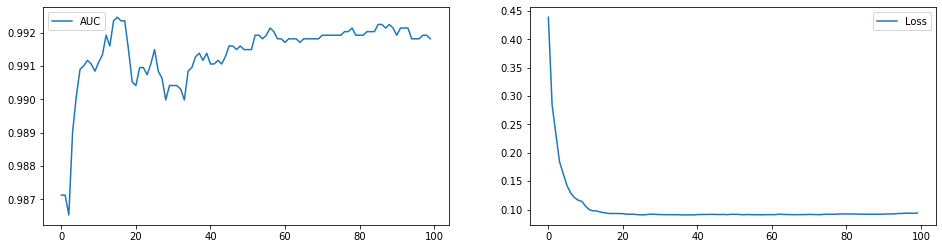

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
ax[0].plot(auc, label='AUC')
ax[1].plot(loss,label='Loss')

ax[0].legend()
ax[1].legend()
plt.show()

In [39]:
# features = 2
# model.plot_partial_dependence(train_data, features)

# model.plot_predictions(train_data, features_to_change=[1,2,3])
# model.plot_tree(tree_idx=0, pool=train_data)

### Predict

In [40]:
y_pred  = model.predict(
        X_test,
        prediction_type='Class',
        ntree_start=0, 
        ntree_end=0, 
        thread_count=-1, 
        verbose=False)

y_score  = model.predict(
        X_test,
        prediction_type='Probability',
        ntree_start=0, 
        ntree_end=0, 
        thread_count=-1, 
        verbose=False)

# Score can also be Obtained using predict_proba
#y_score = model.predict_proba(X_test)

### Performance Metrics on Test Data

In [41]:
from sklearn import metrics

In [42]:
"""Accuracy Score"""
accuracy = metrics.accuracy_score(y_test, y_pred, sample_weight=None, normalize=True)
print( round(accuracy, 4))

0.9602


In [43]:
"""Balanced Accuracy Score"""
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred, sample_weight=None, adjusted=False)
print( round(balanced_accuracy, 4))

0.9593


In [44]:
"""ROC Curve"""
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])

In [45]:
"""AUC"""
auc = metrics.auc(fpr, tpr)
print( round(auc, 4))

0.9953


In [46]:
"""Confusion Matrix"""
metrics.confusion_matrix(y_test, y_pred)

array([[188,   7],
       [  6, 126]])

In [47]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:188, FP:7, FN:6, TP:126


In [48]:
"""F1 Score"""
f1 = metrics.f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
print( round(f1, 4))

0.9509


In [49]:
"""Log Loss"""
metrics.log_loss(y_test, y_score[:, 1], normalize=True, sample_weight=None, labels=[0,1])

0.09253263943759973

In [50]:
"""Precision, Recall, Fscore, Support"""
metrics.precision_recall_fscore_support(y_test, y_pred, labels=[0,1], pos_label=1, 
                                        average=None, sample_weight=None)

(array([0.96907216, 0.94736842]),
 array([0.96410256, 0.95454545]),
 array([0.96658098, 0.9509434 ]),
 array([195, 132]))

In [51]:
precision = metrics.precision_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                                    average='binary', sample_weight=None)
print( round(precision, 4))

0.9474


In [52]:
recall = metrics.recall_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                              average='binary', sample_weight=None)
print( round(recall, 4))

0.9545


Basic Plots

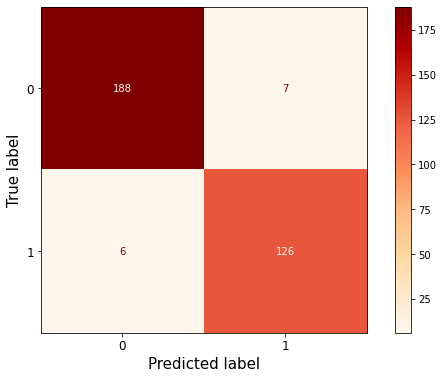

In [53]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel("", fontsize=15)
ax.set_ylabel("", fontsize=15)
ax.set_xticklabels([0,1], fontsize=12)
ax.set_yticklabels([0,1], fontsize=12)

metrics.plot_confusion_matrix(
    model, X_test, y_test, 
    labels=None, sample_weight=None, normalize=None, 
    display_labels=[0,1], 
    cmap='OrRd', 
    #color='w',
    ax=ax)

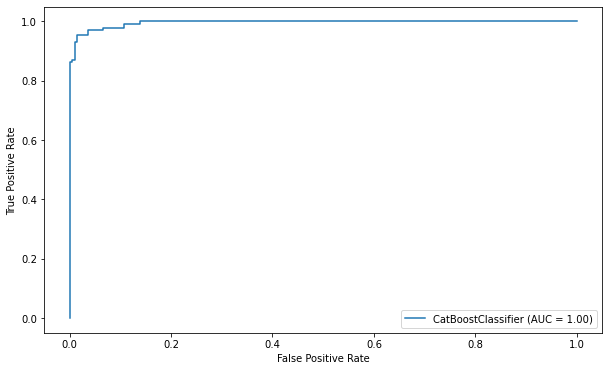

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
metrics.plot_roc_curve(model, X_test, y_test, sample_weight=None, ax=ax)

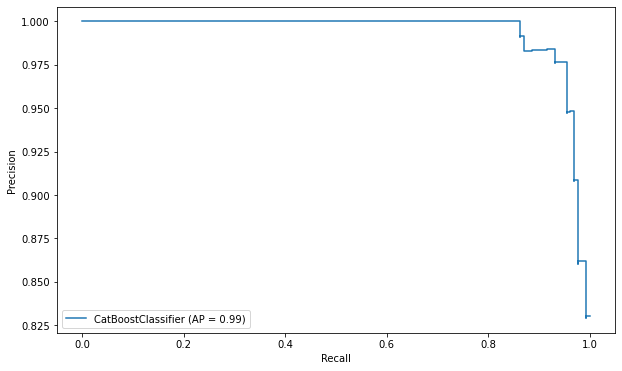

In [55]:
fig, ax = plt.subplots(figsize=(10,6))
metrics.plot_precision_recall_curve(model, X_test, y_test, sample_weight=None, ax=ax)

### SHAP Analysis

In [56]:
import shap
shap.initjs()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [57]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

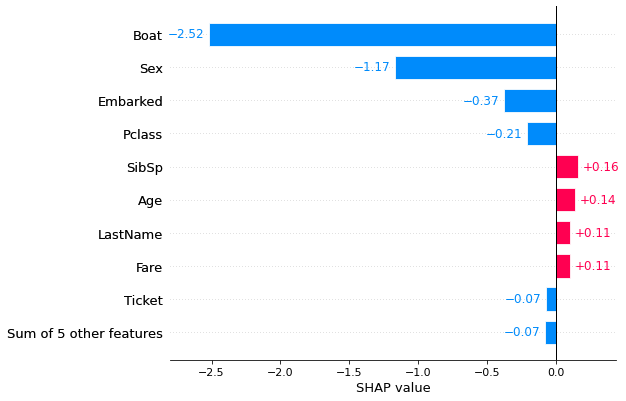

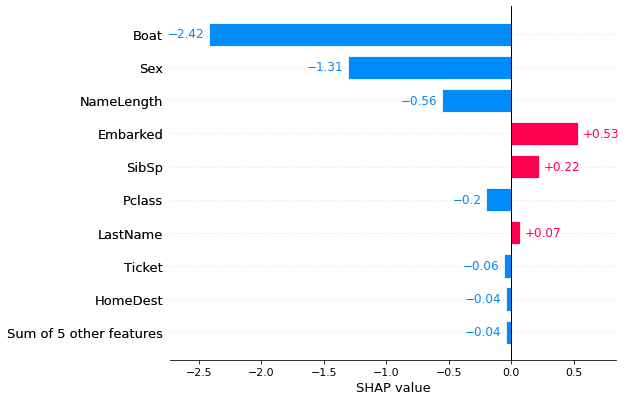

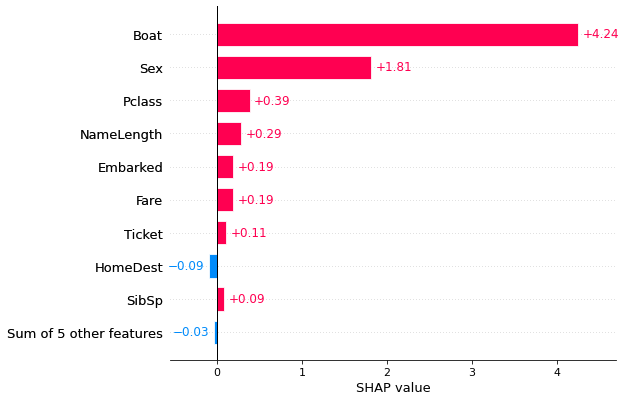

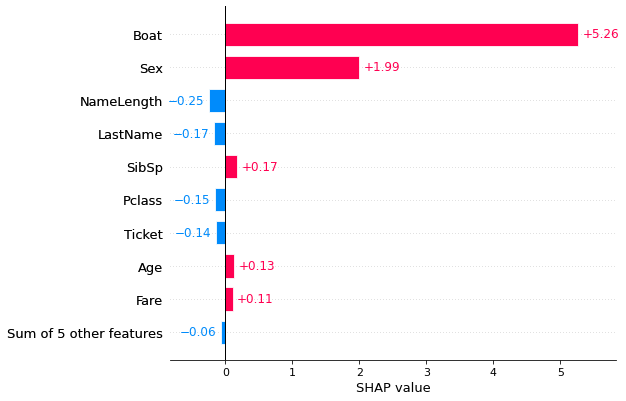

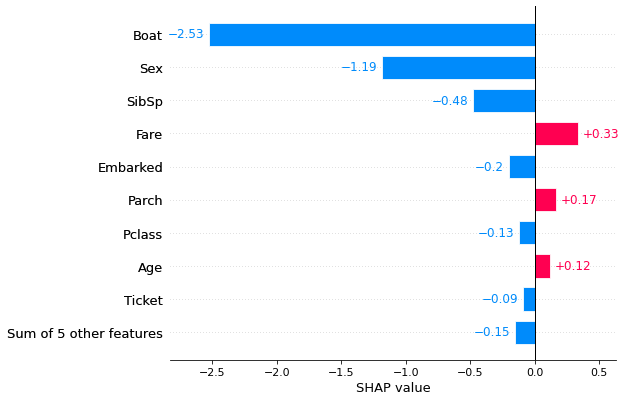

In [58]:
for i in range(5):
    shap.plots.bar(shap_values[i])

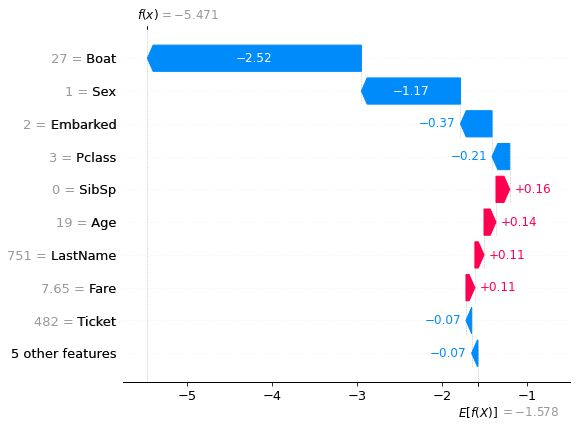

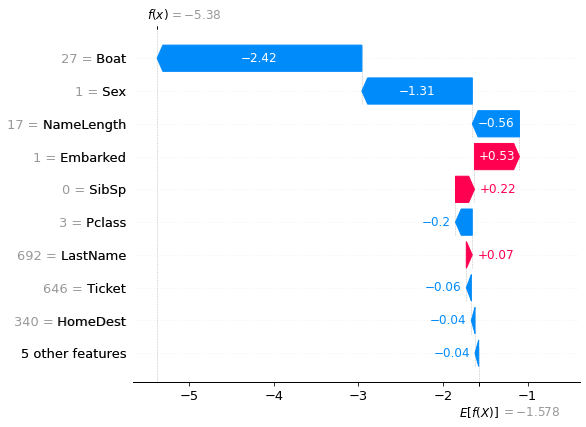

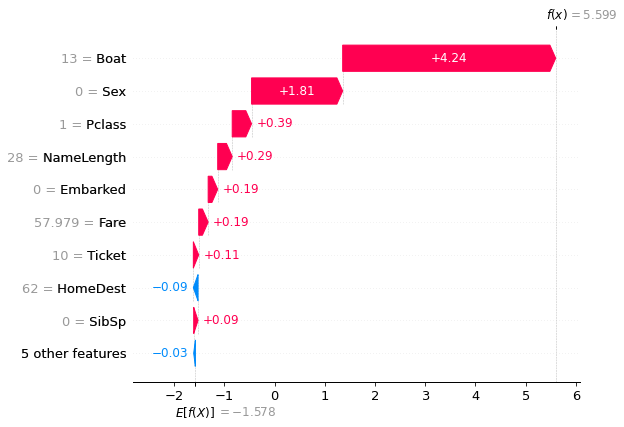

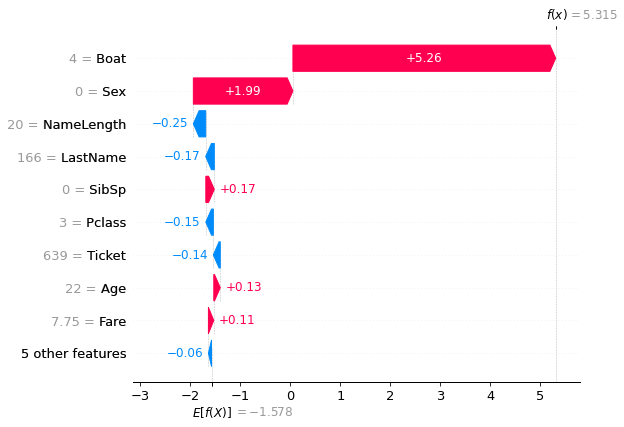

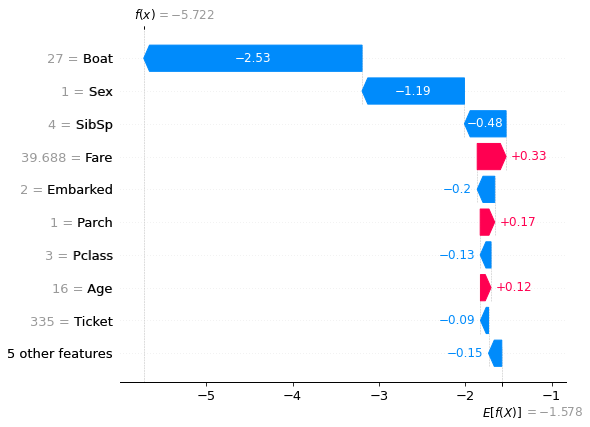

In [59]:
for i in range(5):
    shap.plots.waterfall(shap_values[i])

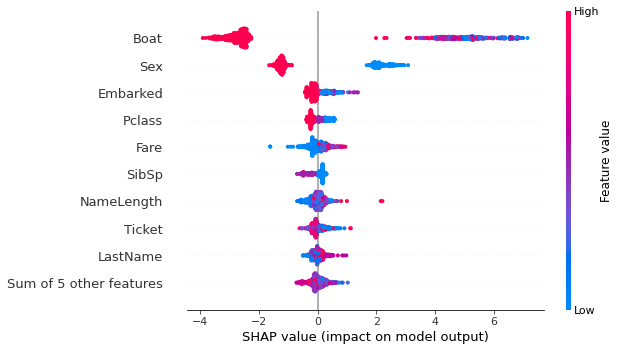

In [60]:
shap.plots.beeswarm(shap_values)

In [61]:
treeExplainer = shap.TreeExplainer(
    model, 
    data=None, 
    feature_perturbation= "tree_path_dependent", 
    model_output='raw')
shap_values = treeExplainer.shap_values(X_train)

Visualize the first prediction's explanation

In [62]:
shap.force_plot(treeExplainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Visualize the Training set Predictions

In [63]:
shap.force_plot(treeExplainer.expected_value, shap_values, X_train)

SHAP Summary Plot

Summarize the effects of all the features

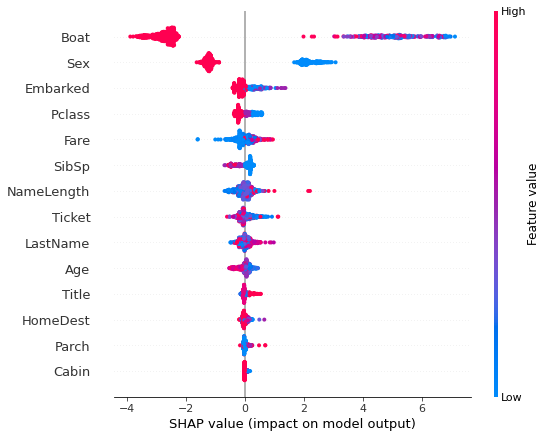

In [64]:
shap.summary_plot(shap_values, X_train)

SHAP Dependence Plot

Create a SHAP dependence plot to show the effect of a single feature across the whole dataset

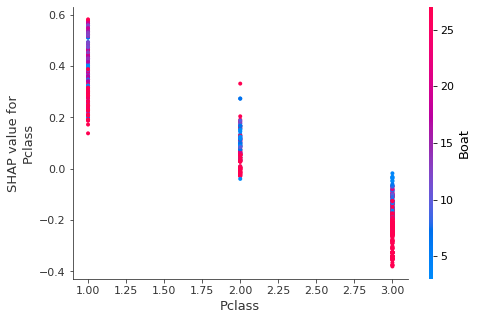

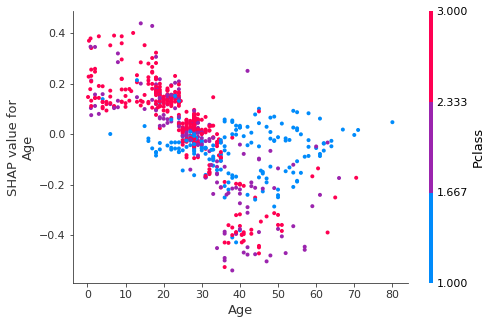

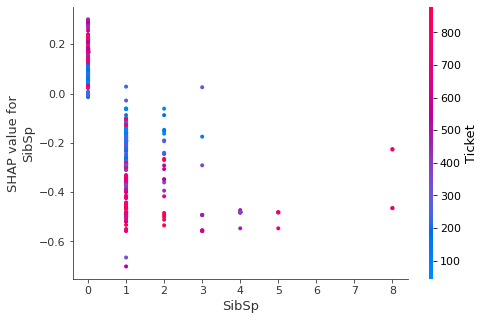

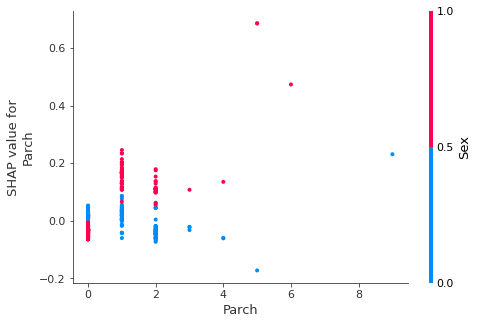

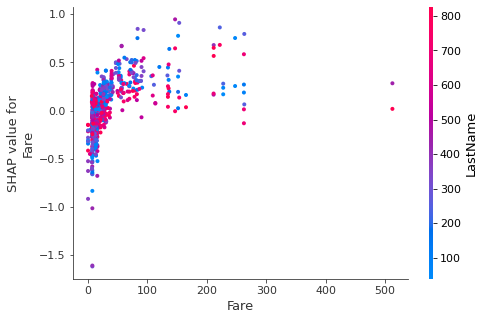

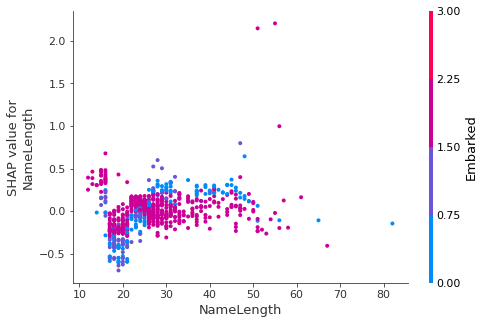

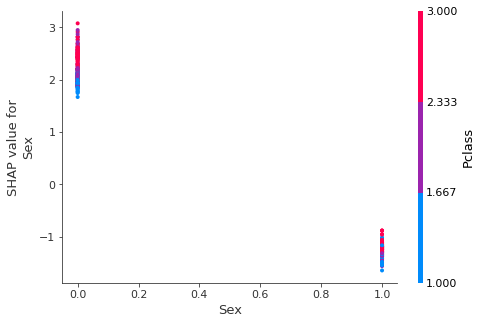

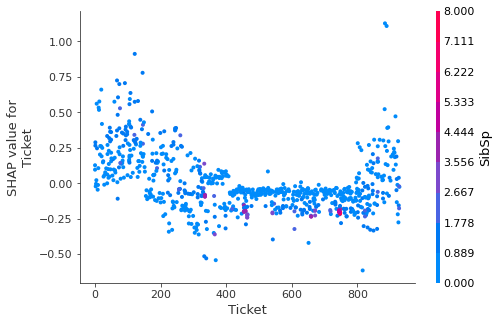

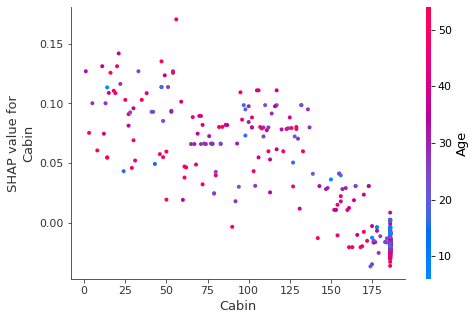

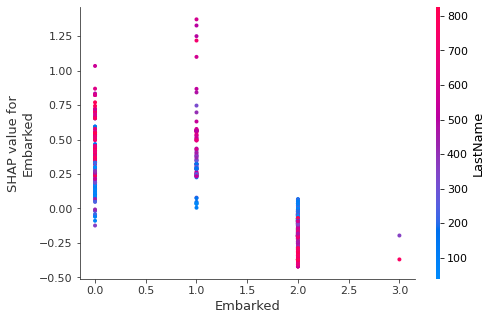

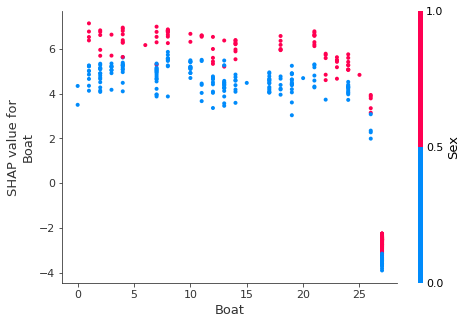

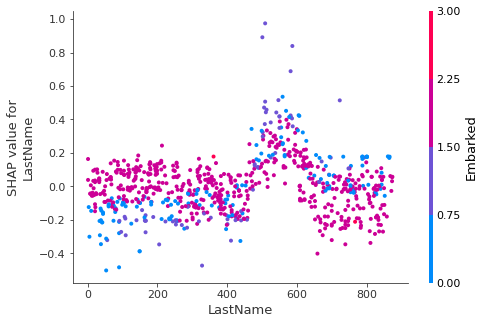

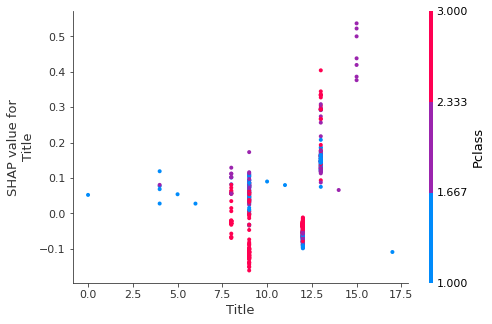

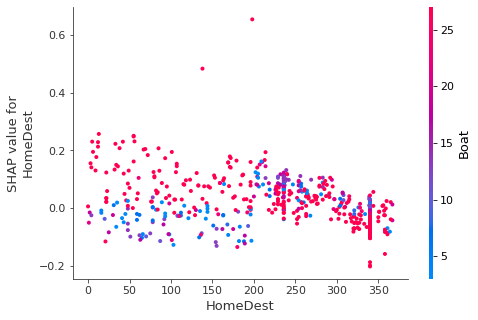

In [65]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

### Probability Calibration

In [66]:
from sklearn.calibration import CalibratedClassifierCV

In [67]:
calibrated_model = CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv='prefit')

In [68]:
calibrated_fit = calibrated_model.fit(X_test, y_test)

In [69]:
calibrated_y_pred  = calibrated_fit.predict(X_test)
calibrated_y_score = calibrated_fit.predict_proba(X_test)

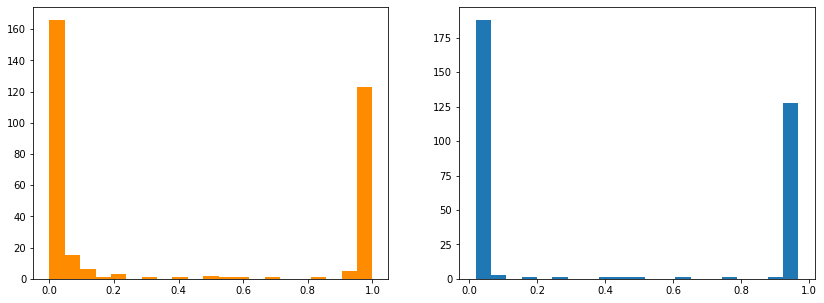

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
ax[0].hist(y_score[:,1], bins=21, color='darkorange')
ax[1].hist(calibrated_y_score[:,1], bins=21)
plt.show()